In [1]:
import os
import glob
import pandas as pd
import numpy as np
import pandas_profiling as pp
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import f_oneway
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

pd.options.display.max_columns = 40

In [2]:
# Downloads data from Kaggle and extracts it from the zip files

# !kaggle competitions download -c recruit-restaurant-visitor-forecasting -p .\Data
# !kaggle datasets download huntermcgushion/rrv-weather-data -p Data\Weather -- unzip

# from zipfile import ZipFile

# for filename in os.listdir('Data'):
#     if filename.endswith('.zip'):
#         with ZipFile('Data\\' + filename) as zip_obj:
#             zip_obj.extractall('Data')

In [3]:
# These are the files provided by the Kaggle competition
visit_data = pd.read_csv('Data/air_visit_data.csv')
date_info = pd.read_csv('Data/date_info.csv')
test = pd.read_csv('Data/sample_submission.csv')

# These files are from weather dataset. The air_store_info_with_nearest_active_station file contains the same data 
# as the air_store_info file provided in the competition, but with extra features that make it easy to merge with
# the weather data.
air_store_weather = pd.read_csv('Data/Weather/air_store_info_with_nearest_active_station.csv')
features = pd.read_csv('Data/Weather/feature_manifest.csv')

# Loading weather data. Each station is kept in a separate csv file. This loads all of them into a single DataFrame.
path = 'Data/Weather/1-1-16_5-31-17_Weather/'
all_files = glob.glob(os.path.join(path, '*.csv'))
weather = pd.concat((pd.read_csv(f).assign(station_id=f.split('\\')[-1].split('.')[0]) for f in all_files),
                    ignore_index=True)
weather['calendar_date'] = pd.to_datetime(weather['calendar_date'])
weather = weather.set_index(['calendar_date', 'station_id']).sort_index()

# There are 108 unique latitude/longitude pairs and over 1,600 weather stations.
# This file contains this distances betweeen each pair.
distances = (pd.read_csv('Data/Weather/air_station_distances.csv', index_col=0)
             .drop(['station_latitude', 'station_longitude'], axis=1))
retired_stations = distances[distances.index.str.contains('___')].index
distances.drop(retired_stations, inplace=True)

In [4]:
visit_data.head()

air_store_id  visit_date  visitors
0  air_ba937bf13d40fb24  2016-01-13        25
1  air_ba937bf13d40fb24  2016-01-14        32
2  air_ba937bf13d40fb24  2016-01-15        29
3  air_ba937bf13d40fb24  2016-01-16        22
4  air_ba937bf13d40fb24  2016-01-18         6

In [5]:
date_info.head()

calendar_date day_of_week  holiday_flg
0    2016-01-01      Friday            1
1    2016-01-02    Saturday            1
2    2016-01-03      Sunday            1
3    2016-01-04      Monday            0
4    2016-01-05     Tuesday            0

In [6]:
test.head()

id  visitors
0  air_00a91d42b08b08d9_2017-04-23         0
1  air_00a91d42b08b08d9_2017-04-24         0
2  air_00a91d42b08b08d9_2017-04-25         0
3  air_00a91d42b08b08d9_2017-04-26         0
4  air_00a91d42b08b08d9_2017-04-27         0

In [7]:
air_store_weather.head()

air_store_id  air_genre_name                 air_area_name  \
0  air_0f0cdeee6c9bf3d7  Italian/French  Hyōgo-ken Kōbe-shi Kumoidōri   
1  air_7cc17a324ae5c7dc  Italian/French  Hyōgo-ken Kōbe-shi Kumoidōri   
2  air_fee8dcf4d619598e  Italian/French  Hyōgo-ken Kōbe-shi Kumoidōri   
3  air_a17f0778617c76e2  Italian/French  Hyōgo-ken Kōbe-shi Kumoidōri   
4  air_83db5aff8f50478e  Italian/French  Tōkyō-to Minato-ku Shibakōen   

    latitude   longitude  latitude_str  longitude_str  \
0  34.695124  135.197852  "34.6951242"  "135.1978525"   
1  34.695124  135.197852  "34.6951242"  "135.1978525"   
2  34.695124  135.197852  "34.6951242"  "135.1978525"   
3  34.695124  135.197852  "34.6951242"  "135.1978525"   
4  35.658068  139.751599  "35.6580681"  "139.7515992"   

                   station_id  station_latitude  station_longitude  \
0     hyogo__kobe-kana__koube         34.696667         135.211667   
1     hyogo__kobe-kana__koube         34.696667         135.211667   
2     hyogo__kobe-kana__koube         34.696667         135.211667   
3     hyogo__kobe-kana__koube         34.696667         135.211667   
4  tokyo__tokyo-kana__tonokyo         35.691667         139.750000   

   station_vincenty  station_great_circle  
0          1.277232              1.274882  
1          1.277232              1.274882  
2          1.277232              1.274882  
3          1.277232              1.274882  
4          3.730672              3.739835

In [8]:
features.head()

id  avg_temperature  high_temperature  \
0                aichi__ai-xi-kana__isaai              1.0               1.0   
1                    aichi__aki-kana__azo              0.0               0.0   
2          aichi__centrair-kana__centrair              1.0               1.0   
3  aichi__chapel-mountain-kana__chaw-yama              0.0               0.0   
4          aichi__gamagori-kana__gamagori              1.0               1.0   

   low_temperature  precipitation  hours_sunlight  solar_radiation  \
0              1.0            1.0             1.0              0.0   
1              0.0            1.0             0.0              0.0   
2              1.0            1.0             0.0              0.0   
3              0.0            1.0             0.0              0.0   
4              1.0            1.0             1.0              0.0   

   deepest_snowfall  total_snowfall  avg_wind_speed  avg_vapor_pressure  \
0               0.0             0.0             1.0                 0.0   
1               0.0             0.0             0.0                 0.0   
2               0.0             0.0             1.0                 0.0   
3               0.0             0.0             0.0                 0.0   
4               0.0             0.0             1.0                 0.0   

   avg_local_pressure  avg_humidity  avg_sea_pressure  cloud_cover  
0                 0.0           0.0               0.0          0.0  
1                 0.0           0.0               0.0          0.0  
2                 0.0           0.0               0.0          0.0  
3                 0.0           0.0               0.0          0.0  
4                 0.0           0.0               0.0          0.0

In [9]:
weather.head()

avg_temperature  \
calendar_date station_id                                                
2016-01-01    aichi__ai-xi-kana__isaai                            6.0   
              aichi__aki-kana__azo                                NaN   
              aichi__centrair-kana__centrair                      8.9   
              aichi__chapel-mountain-kana__chaw-yama              NaN   
              aichi__gamagori-kana__gamagori                      6.6   

                                                      high_temperature  \
calendar_date station_id                                                 
2016-01-01    aichi__ai-xi-kana__isaai                            11.0   
              aichi__aki-kana__azo                                 NaN   
              aichi__centrair-kana__centrair                      11.1   
              aichi__chapel-mountain-kana__chaw-yama               NaN   
              aichi__gamagori-kana__gamagori                      11.2   

                                                      low_temperature  \
calendar_date station_id                                                
2016-01-01    aichi__ai-xi-kana__isaai                            0.7   
              aichi__aki-kana__azo                                NaN   
              aichi__centrair-kana__centrair                      5.9   
              aichi__chapel-mountain-kana__chaw-yama              NaN   
              aichi__gamagori-kana__gamagori                      2.5   

                                                      precipitation  \
calendar_date station_id                                              
2016-01-01    aichi__ai-xi-kana__isaai                          0.0   
              aichi__aki-kana__azo                              0.0   
              aichi__centrair-kana__centrair                    0.0   
              aichi__chapel-mountain-kana__chaw-yama            0.0   
              aichi__gamagori-kana__gamagori                    0.0   

                                                      hours_sunlight  \
calendar_date station_id                                               
2016-01-01    aichi__ai-xi-kana__isaai                           9.1   
              aichi__aki-kana__azo                               NaN   
              aichi__centrair-kana__centrair                     NaN   
              aichi__chapel-mountain-kana__chaw-yama             NaN   
              aichi__gamagori-kana__gamagori                     9.4   

                                                      solar_radiation  \
calendar_date station_id                                                
2016-01-01    aichi__ai-xi-kana__isaai                            NaN   
              aichi__aki-kana__azo                                NaN   
              aichi__centrair-kana__centrair                      NaN   
              aichi__chapel-mountain-kana__chaw-yama              NaN   
              aichi__gamagori-kana__gamagori                      NaN   

                                                      deepest_snowfall  \
calendar_date station_id                                                 
2016-01-01    aichi__ai-xi-kana__isaai                             NaN   
              aichi__aki-kana__azo                                 NaN   
              aichi__centrair-kana__centrair                       NaN   
              aichi__chapel-mountain-kana__chaw-yama               NaN   
              aichi__gamagori-kana__gamagori                       NaN   

                                                      total_snowfall  \
calendar_date station_id                                               
2016-01-01    aichi__ai-xi-kana__isaai                           NaN   
              aichi__aki-kana__azo                               NaN   
              aichi__centrair-kana__centrair                     NaN   
              aichi__chapel-mountain-kana__chaw-yama             NaN   
              aichi__gamagori-kana__gamagori 

In [10]:
distances.head()

(34.6951242, 135.1978525)  \
station_id                                                          
aichi__ai-xi-kana__isaai                               148.760474   
aichi__aki-kana__azo                                   206.934423   
aichi__centrair-kana__centrair                         148.219287   
aichi__chapel-mountain-kana__chaw-yama                 232.290097   
aichi__gamagori-kana__gamagori                         185.551102   

                                        (35.6580681, 139.7515992)  \
station_id                                                          
aichi__ai-xi-kana__isaai                               281.515494   
aichi__aki-kana__azo                                   222.009692   
aichi__centrair-kana__centrair                         282.425838   
aichi__chapel-mountain-kana__chaw-yama                 196.028930   
aichi__gamagori-kana__gamagori                         247.697421   

                                        (33.5892157, 130.3928134)  \
station_id                                                          
aichi__ai-xi-kana__isaai                               607.092649   
aichi__aki-kana__azo                                   666.658179   
aichi__centrair-kana__centrair                         607.247882   
aichi__chapel-mountain-kana__chaw-yama                 692.042696   
aichi__gamagori-kana__gamagori                         643.912231   

                                        (35.6465721, 139.6532473)  \
station_id                                                          
aichi__ai-xi-kana__isaai                               272.519535   
aichi__aki-kana__azo                                   213.104447   
aichi__centrair-kana__centrair                         273.551438   
aichi__chapel-mountain-kana__chaw-yama                 187.076948   
aichi__gamagori-kana__gamagori                         238.921222   

                                        (34.7053617, 135.5100252)  \
station_id                                                          
aichi__ai-xi-kana__isaai                               122.458285   
aichi__aki-kana__azo                                   178.827179   
aichi__centrair-kana__centrair                         119.736543   
aichi__chapel-mountain-kana__chaw-yama                 204.483249   
aichi__gamagori-kana__gamagori                         156.985300   

                                        (35.6617773, 139.7040506)  \
station_id                                                          
aichi__ai-xi-kana__isaai                               277.332264   
aichi__aki-kana__azo                                   217.995118   
aichi__centrair-kana__centrair                         278.447541   
aichi__chapel-mountain-kana__chaw-yama                 191.950202   
aichi__gamagori-kana__gamagori                         243.820606   

                                        (35.6995657, 139.6364379)  \
station_id                                                          
aichi__ai-xi-kana__isaai                               272.027251   
aichi__aki-kana__azo                                   213.408094   
aichi__centrair-kana__centrair                         273.969304   
aichi__chapel-mountain-kana__chaw-yama                 187.129755   
aichi__gamagori-kana__gamagori                         239.699305   

                                        (34.3862445, 132.4550176)  \
station_id                                                          
aichi__ai-xi-kana__isaai                               399.040385   
aichi__aki-kana__azo                                   460.497590   
aichi__centrair-kana__centrair                         402.307593   
aichi__chapel-mountain-kana__chaw-yama                 485.124065   
aichi__gamagori-kana__gamagori                         439.617310   

                                        (35.6721142, 139.7708253)  \
station_id                                                          
aichi__ai-xi-kana__isaai      

In [11]:
features.describe()

avg_temperature  high_temperature  low_temperature  precipitation  \
count      1663.000000       1663.000000      1663.000000    1663.000000   
mean          0.558560          0.558508         0.558508       0.744709   
std           0.495644          0.495598         0.495598       0.407874   
min           0.000000          0.000000         0.000000       0.000000   
25%           0.000000          0.000000         0.000000       0.578337   
50%           0.998066          0.996132         0.996132       1.000000   
75%           1.000000          1.000000         1.000000       1.000000   
max           1.000000          1.000000         1.000000       1.000000   

       hours_sunlight  solar_radiation  deepest_snowfall  total_snowfall  \
count     1663.000000      1663.000000       1663.000000     1663.000000   
mean         0.504173         0.028848          0.144023        0.139755   
std          0.498516         0.167386          0.341394        0.339987   
min          0.000000         0.000000          0.000000        0.000000   
25%          0.000000         0.000000          0.000000        0.000000   
50%          0.965184         0.000000          0.000000        0.000000   
75%          1.000000         0.000000          0.000000        0.000000   
max          1.000000         1.000000          1.000000        1.000000   

       avg_wind_speed  avg_vapor_pressure  avg_local_pressure  avg_humidity  \
count     1663.000000         1663.000000         1663.000000   1663.000000   
mean         0.550155            0.093494            0.094267      0.093495   
std          0.490407            0.290432            0.292093      0.290433   
min          0.000000            0.000000            0.000000      0.000000   
25%          0.000000            0.000000            0.000000      0.000000   
50%          0.965184            0.000000            0.000000      0.000000   
75%          0.998066            0.000000            0.000000      0.000000   
max          1.000000            1.000000            1.000000      1.000000   

       avg_sea_pressure  cloud_cover  
count       1663.000000  1663.000000  
mean           0.090785     0.035372  
std            0.287363     0.184538  
min            0.000000     0.000000  
25%            0.000000     0.000000  
50%            0.000000     0.000000  
75%            0.000000     0.000000  
max            1.000000     1.000000

In [12]:
features[(features.avg_temperature==1) & (features.precipitation==1)].describe()

avg_temperature  high_temperature  low_temperature  precipitation  \
count            568.0        568.000000       568.000000          568.0   
mean               1.0          0.999949         0.999949            1.0   
std                0.0          0.000478         0.000478            0.0   
min                1.0          0.992263         0.992263            1.0   
25%                1.0          1.000000         1.000000            1.0   
50%                1.0          1.000000         1.000000            1.0   
75%                1.0          1.000000         1.000000            1.0   
max                1.0          1.000000         1.000000            1.0   

       hours_sunlight  solar_radiation  deepest_snowfall  total_snowfall  \
count      568.000000            568.0        568.000000      568.000000   
mean         0.949519              0.0          0.256719        0.256664   
std          0.216440              0.0          0.436843        0.436751   
min          0.000000              0.0          0.000000        0.000000   
25%          0.998066              0.0          0.000000        0.000000   
50%          1.000000              0.0          0.000000        0.000000   
75%          1.000000              0.0          0.991296        0.990329   
max          1.000000              0.0          1.000000        1.000000   

       avg_wind_speed  avg_vapor_pressure  avg_local_pressure  avg_humidity  \
count      568.000000               568.0               568.0         568.0   
mean         0.986668                 0.0                 0.0           0.0   
std          0.021250                 0.0                 0.0           0.0   
min          0.856867                 0.0                 0.0           0.0   
25%          0.982592                 0.0                 0.0           0.0   
50%          0.996132                 0.0                 0.0           0.0   
75%          1.000000                 0.0                 0.0           0.0   
max          1.000000                 0.0                 0.0           0.0   

       avg_sea_pressure  cloud_cover  
count             568.0        568.0  
mean                0.0          0.0  
std                 0.0          0.0  
min                 0.0          0.0  
25%                 0.0          0.0  
50%                 0.0          0.0  
75%                 0.0          0.0  
max                 0.0          0.0

Looking through the feature manifest which contains a 1 if that measurement is available for all days at a given weather station and a 0 if it not available for any days, I found that no stations measure everything all the time. To reduce the number of missing values, I will average the 5 closest stations for each latitude/longitude pair.

In [13]:
def closest_five_stations(srs):
    smallest = srs.sort_values()[0:5].index
    is_lowest = pd.Series(0, index=srs.index)
    is_lowest.loc[smallest] = 1
    return is_lowest

closest = distances.apply(lambda srs: closest_five_stations(srs))

In [14]:
dates = weather.index.get_level_values('calendar_date').unique()
locations = closest.columns
measurements = weather.columns
new_index = pd.MultiIndex.from_product([locations, dates], names=['location', 'calendar_date'])
average_weather = pd.DataFrame(0, index=new_index, columns=measurements)
average_weather.sort_index(level=[0,1], inplace=True)

In [15]:
for date in weather.index.get_level_values('calendar_date').unique():
    current_dates_weather = weather.loc[date]
    for location in average_weather.index.get_level_values('location').unique():
        locations_to_average = closest[closest.loc[:,location].astype('bool')].index
        average_weather.loc[(location, date), :] = (current_dates_weather
                                                    .loc[locations_to_average, :]
                                                    .mean())

In [16]:
average_weather.head()

avg_temperature  high_temperature  \
location                  calendar_date                                      
(33.2119674, 130.5579082) 2016-01-01            4.466667         11.066667   
                          2016-01-02            9.066667         14.466667   
                          2016-01-03           11.000000         16.266667   
                          2016-01-04            8.866667         15.200000   
                          2016-01-05            8.266667         11.633333   

                                         low_temperature  precipitation  \
location                  calendar_date                                   
(33.2119674, 130.5579082) 2016-01-01           -0.400000            0.0   
                          2016-01-02            4.266667            0.2   
                          2016-01-03            6.333333            0.0   
                          2016-01-04            4.533333            0.0   
                          2016-01-05            6.600000            3.6   

                                         hours_sunlight  solar_radiation  \
location                  calendar_date                                    
(33.2119674, 130.5579082) 2016-01-01           8.366667              NaN   
                          2016-01-02           0.900000              NaN   
                          2016-01-03           0.366667              NaN   
                          2016-01-04           5.733333              NaN   
                          2016-01-05           0.000000              NaN   

                                         deepest_snowfall  total_snowfall  \
location                  calendar_date                                     
(33.2119674, 130.5579082) 2016-01-01                  NaN             NaN   
                          2016-01-02                  NaN             NaN   
                          2016-01-03                  NaN             NaN   
                          2016-01-04                  NaN             NaN   
                          2016-01-05                  NaN             NaN   

                                         avg_wind_speed  avg_vapor_pressure  \
location                  calendar_date                                       
(33.2119674, 130.5579082) 2016-01-01           0.800000                 NaN   
                          2016-01-02           0.700000                 NaN   
                          2016-01-03           0.700000                 NaN   
                          2016-01-04           0.666667                 NaN   
                          2016-01-05           1.300000                 NaN   

                                         avg_local_pressure  avg_humidity  \
location                  calendar_date                                     
(33.2119674, 130.5579082) 2016-01-01                    NaN           NaN   
                          2016-01-02                    NaN           NaN   
                          2016-01-03                    NaN           NaN   
                          2016-01-04                    NaN           NaN   
                          2016-01-05                    NaN           NaN   

                                         avg_sea_pressure  cloud_cover  
location                  calendar_date                                 
(33.2119674, 130.5579082) 2016-01-01                  NaN          NaN  
                          2016-01-02                  NaN          NaN  
                          2016-01-03                  NaN          NaN  
                          2016-01-04                  NaN          NaN  
                          2016-01-05                  NaN          NaN

Before merging these datasets need some processing.

In [17]:
air_store_weather.set_index('air_store_id', inplace=True)
air_store_weather['location'] = ('(' + air_store_weather['latitude_str'].str.strip('\"') + ', ' +
                                 air_store_weather['longitude_str'].str.strip('\"') + ')')

test['air_store_id'] = test['id'].str.slice(0, 20)
test['calendar_date'] = test['id'].str.slice(21)
test['calendar_date'] = pd.to_datetime(test['calendar_date'])
test['visitors'] = np.nan
test['is_test'] = True

visit_data.columns = ['air_store_id', 'calendar_date', 'visitors']
visit_data.index = pd.to_datetime(visit_data['calendar_date'])
visit_data = visit_data.groupby('air_store_id').apply(lambda g: g['visitors'].resample('1d').sum()).reset_index()
visit_data['was_closed'] = visit_data['visitors']==0
visit_data_all = pd.concat((visit_data, test.drop('id', axis='columns')), sort=True)
visit_data_all['is_test'].fillna(False, inplace=True)

date_info['calendar_date'] = pd.to_datetime(date_info['calendar_date'])
average_weather.reset_index(inplace=True)
average_weather['calendar_date'] = pd.to_datetime(average_weather['calendar_date'])

In [18]:
df = (date_info
      .merge(visit_data_all, how='left', on='calendar_date')
      .merge(air_store_weather, how='left', on='air_store_id')
      .merge(average_weather, how='left', on=['location', 'calendar_date'])
)

df['city'] = [x[0] for x in df['air_area_name'].str.split()]
df['prefecture'] = [x[1] for x in df['air_area_name'].str.split()]
df['subprefecture'] = [x[2] for x in df['air_area_name'].str.split()]
df.drop('air_area_name', inplace=True, axis=1)

In [19]:
df.head()

calendar_date day_of_week  holiday_flg          air_store_id  is_test  \
0    2016-01-01      Friday            1  air_04341b588bde96cd    False   
1    2016-01-01      Friday            1  air_05c325d315cc17f5    False   
2    2016-01-01      Friday            1  air_08ba8cd01b3ba010    False   
3    2016-01-01      Friday            1  air_09a845d5b5944b01    False   
4    2016-01-01      Friday            1  air_1f7f8fa557bc0d55    False   

   visitors was_closed air_genre_name   latitude   longitude  latitude_str  \
0      10.0      False        Izakaya  35.735623  139.651658  "35.7356234"   
1      29.0      False        Izakaya  33.589216  130.392813  "33.5892157"   
2      11.0      False        Izakaya  38.269076  140.870403  "38.2690761"   
3      56.0      False        Izakaya  33.319286  130.508374  "33.3192865"   
4       6.0      False   Bar/Cocktail  34.766093  135.628100  "34.7660929"   

   longitude_str                      station_id  station_latitude  \
0  "139.6516577"      tokyo__nerima-kana__nerima         35.738333   
1  "130.3928134"  fukuoka__fukuoka-kana__fukuoka         33.581667   
2  "140.8704029"     miyagi__sendai-kana__sendai         38.261667   
3  "130.5083735"    fukuoka__kurume-kana__kurume         33.303333   
4  "135.6280998"  osaka__hirakata-kana__hirakata         34.808333   

   station_longitude  station_vincenty  station_great_circle  \
0         139.591667          5.435240              5.424557   
1         130.375000          1.853535              1.851854   
2         140.896667          2.441192              2.437165   
3         130.493333          2.256617              2.258974   
4         135.671667          6.152897              6.157249   

                    location  avg_temperature  high_temperature  \
0  (35.7356234, 139.6516577)         6.625000         12.000000   
1  (33.5892157, 130.3928134)         6.550000         11.975000   
2  (38.2690761, 140.8704029)         2.466667          6.333333   
3  (33.3192865, 130.5083735)         5.233333         10.933333   
4  (34.7660929, 135.6280998)         5.000000         10.200000   

   low_temperature  precipitation  hours_sunlight  solar_radiation  \
0         1.450000            0.0        9.175000            11.80   
1         1.750000            0.0        6.233333            10.35   
2        -1.833333            0.3        4.950000             5.71   
3         0.966667            0.0        7.166667              NaN   
4         0.900000            0.1        7.450000            11.94   

   deepest_snowfall  total_snowfall  avg_wind_speed  avg_vapor_pressure  \
0               NaN             NaN        1.925000                 4.5   
1               NaN             NaN        2.200000                 7.6   
2               NaN             NaN        3.300000                 4.6   
3               NaN             NaN        1.266667                 NaN   
4               NaN             NaN        1.500000                 6.1   

   avg_local_pressure  avg_humidity  avg_sea_pressure  cloud_cover  \
0              1022.4          45.0            1025.4          2.5   
1              1029.2          76.0            1031.1          4.3   
2              1019.1          64.0            1024.7          4.0   
3                 NaN           NaN               NaN          NaN   
4              1019.4          59.0            1029.7          1.0   

          city    prefecture subprefecture  
0     Tōkyō-to     Nerima-ku  Toyotamakita  
1  Fukuoka-ken   Fukuoka-shi        Daimyō  
2   Miyagi-ken    Sendai-shi      Kamisugi  
3  Fukuoka-ken    Kurume-shi    Jōnanmachi  
4     Ōsaka-fu  Neyagawa-shi      Honmachi

In [20]:
df.isna().sum().sort_values(ascending=False)

total_snowfall          304750
deepest_snowfall        303083
solar_radiation          38420
visitors                 32019
was_closed               32019
cloud_cover              26436
avg_humidity             11099
avg_vapor_pressure       11099
avg_sea_pressure         10668
avg_local_pressure       10668
avg_wind_speed               7
latitude_str                 0
longitude                    0
latitude                     0
air_genre_name               0
subprefecture                0
is_test                      0
air_store_id                 0
holiday_flg                  0
station_id                   0
day_of_week                  0
longitude_str                0
location                     0
station_latitude             0
station_longitude            0
station_vincenty             0
station_great_circle         0
prefecture                   0
avg_temperature              0
high_temperature             0
low_temperature              0
precipitation                0
hours_su

The two snowfall features have more than 90% missing so I will drop them. There are also many extra location columns that are not needed anymore.

In [21]:
columns_to_drop = ['latitude_str', 'longitude_str', 'station_id', 'station_latitude', 'station_longitude', 
                   'station_vincenty', 'station_great_circle', 'location', 'total_snowfall', 'deepest_snowfall']
df.drop(columns=columns_to_drop, inplace=True)

The rest of the weather features with missing values I will fill based on the city and the date.

In [22]:
def fill_missing_weather(row):
    for col in missing_cols:
        if np.isnan(row[col]):
            row[col] = fill_values_city_date[col][(row['city'], row['calendar_date'])]
            if np.isnan(row[col]):
                row[col] = fill_values_date[col][row['calendar_date']]
    return row

missing_cols = ['solar_radiation', 'visitors','cloud_cover', 'avg_humidity',
                'avg_vapor_pressure', 'avg_local_pressure', 'avg_sea_pressure', 'avg_wind_speed']
fill_values_city_date = df.groupby(by=['city', 'calendar_date'])[missing_cols].mean().to_dict()
fill_values_date = df.groupby(by=['calendar_date'])[missing_cols].mean().to_dict()
df.loc[df.isna().any(axis=1)] = df[df.isna().any(axis=1)].apply(fill_missing_weather, axis=1)

In [23]:
df.isna().sum().sort_values(ascending=False)

visitors              32019
was_closed            32019
subprefecture             0
high_temperature          0
day_of_week               0
holiday_flg               0
air_store_id              0
is_test                   0
air_genre_name            0
latitude                  0
longitude                 0
avg_temperature           0
low_temperature           0
prefecture                0
precipitation             0
hours_sunlight            0
solar_radiation           0
avg_wind_speed            0
avg_vapor_pressure        0
avg_local_pressure        0
avg_humidity              0
avg_sea_pressure          0
cloud_cover               0
city                      0
calendar_date             0
dtype: int64

In [24]:
categoricals = ['city', 'prefecture', 'subprefecture', 'air_genre_name', 'day_of_week']
df[categoricals] = df[categoricals].astype('category')
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['day_of_week'] = df['day_of_week'].cat.reorder_categories(day_order, ordered=True)
df['calendar_date'] = pd.to_datetime(df['calendar_date'])
df['year'] = df['calendar_date'].dt.year
df['month'] = df['calendar_date'].dt.month
df['day'] = df['calendar_date'].dt.day
df.set_index(['air_store_id', 'calendar_date'], inplace=True)
df.sort_index(inplace=True)

In [25]:
df[~df['is_test']].profile_report(plot={'histogram':{'bayesian_blocks_bins': False}})

In [26]:
rejected = ['avg_sea_pressure', 'avg_vapor_pressure', 'high_temperature', 'low_temperature']
df.drop(labels=rejected, axis=1, inplace=True)

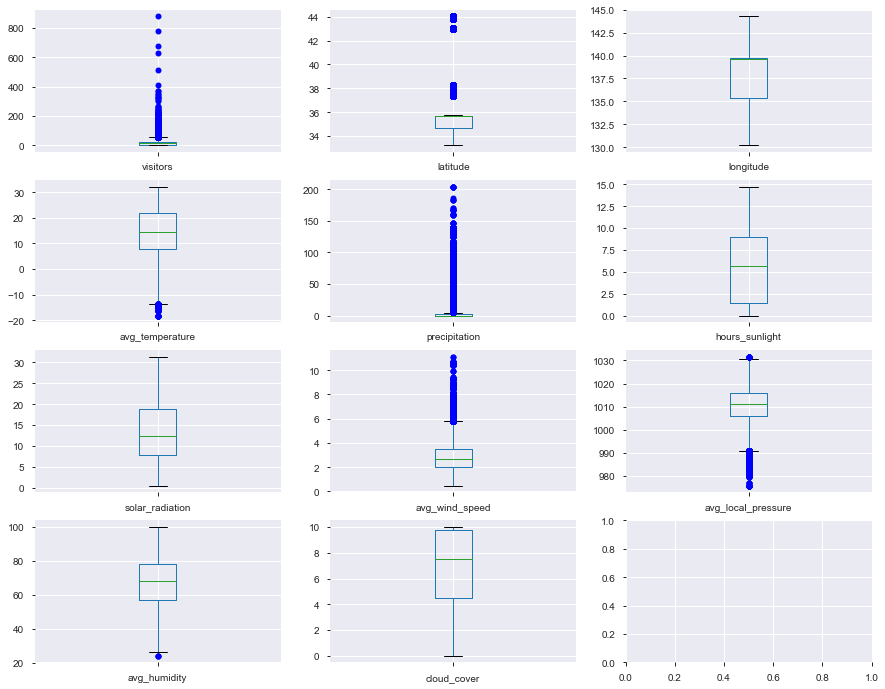

In [27]:
continuous = df.loc[:,df.dtypes == 'float64'].copy()
f, axes = plt.subplots(4, 3, figsize=(15,12))
for k, col in enumerate(continuous.columns):
    continuous.boxplot(column=col, ax=axes[k//3, k%3], sym='bo')

In [28]:
print('Visitors: ' + str(df[df['visitors']>59].iloc[:,0].count()))
print('Temperature: ' + str(df[df['avg_temperature']<-15.17].iloc[:,0].count()))
print('Precipitation: ' + str(df[df['precipitation']>5.25].iloc[:,0].count()))
print('Wind Speed: ' + str(df[df['avg_wind_speed']>5.795].iloc[:,0].count()))

Visitors: 6959
Temperature: 30
Precipitation: 56535
Wind Speed: 8059


|- |Visitors  |Temperature  |Precipitation	|Wind Speed  |  
|---|---|---|---|---| 
|Maximum|877|-18.12|204.1|10.7|  
|95%	|52|2.87|23.3|5.13|  
|Whisker|59|-15.2|5.25|5.8|  
|Count	|6,959|26|48,329|7,065|  
|Percent|2.8%|0.01%|19.2%|2.8%|  


How I will deal with outliers:  
- Temperature: No change because there are so few outside the whiskers and they are relatively close.
- Viistors: No change because it is the target.
- Wind Speed: I will adjust the values so that the maximum value is at the edge of the whisker.
- Precipitation: I will adjust the values so that the maximum value is the same as the 95th percentile. With >50% of the values being 0, using the end of the whiskers would mean changing 19% of the values.

In [29]:
precip95 = np.percentile(df['precipitation'], 95)
df.loc[df['precipitation'] > precip95, 'precipitation'] = precip95

In [30]:
def remove_outlier(df, col):
    quartiles = np.percentile(df[col].dropna(), [25, 75])
    iqr = quartiles[1] - quartiles[0]
    whisker = quartiles[1] + (iqr * 1.5)
    df.loc[df[col] > whisker, col] = whisker
    
remove_outlier(df, 'avg_wind_speed')

In [31]:
df.reset_index(level='air_store_id', inplace=True)

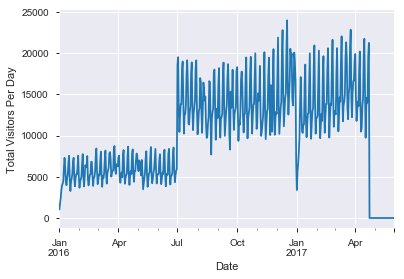

In [32]:
df.groupby(df.index)['visitors'].sum().plot()
plt.xlabel('Date')
plt.ylabel('Total Visitors Per Day')
plt.show()

It is difficult to count exactly, but there seems to be 3-5 peaks in each month which would imply that there is a weekly variation. There is also a sudden change in the number of visitors at the beginning of July.

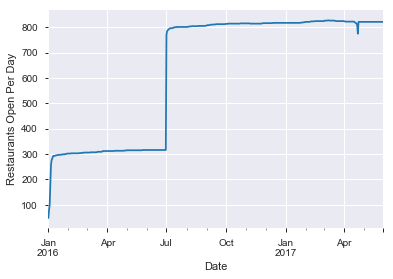

In [33]:
df.groupby(df.index)['air_store_id'].count().plot()
plt.xlabel('Date')
plt.ylabel('Restaurants Open Per Day')
plt.show()

The change in visitors starting in July corresponds to an increase in the number of restaurants.  
I will start looking at average visitors to account for the change in number of restaurants.

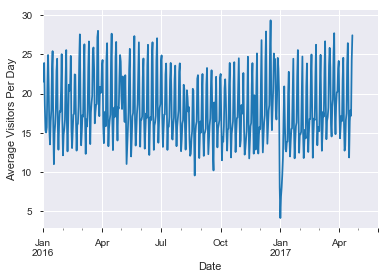

In [34]:
df.groupby(df.index)['visitors'].mean().plot()
plt.xlabel('Date')
plt.ylabel('Average Visitors Per Day')
plt.show()

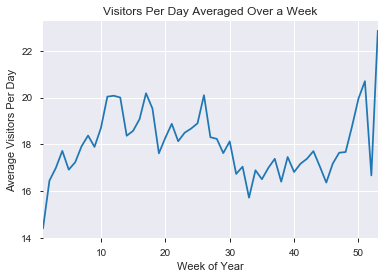

In [35]:
df.groupby(df.index.week)['visitors'].mean().plot()
plt.xlabel('Week of Year')
plt.ylabel('Average Visitors Per Day')
plt.title('Visitors Per Day Averaged Over a Week')
plt.show()

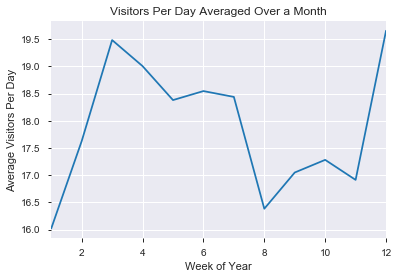

In [36]:
df.groupby(df.index.month)['visitors'].mean().plot()
plt.xlabel('Week of Year')
plt.ylabel('Average Visitors Per Day')
plt.title('Visitors Per Day Averaged Over a Month')
plt.show()

As longer time periods are averaged over, a seasonal variation becomes more apparent.

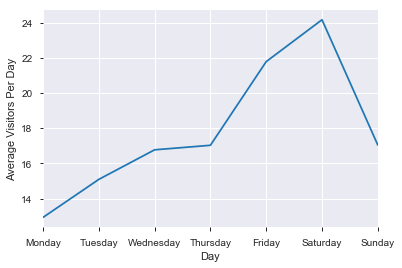

In [37]:
df.groupby(df.day_of_week)['visitors'].mean().plot()
plt.xlabel('Day')
plt.ylabel('Average Visitors Per Day')
plt.show()

The weekend has the highest number of visitors with Saturday being ~50% more than Monday.

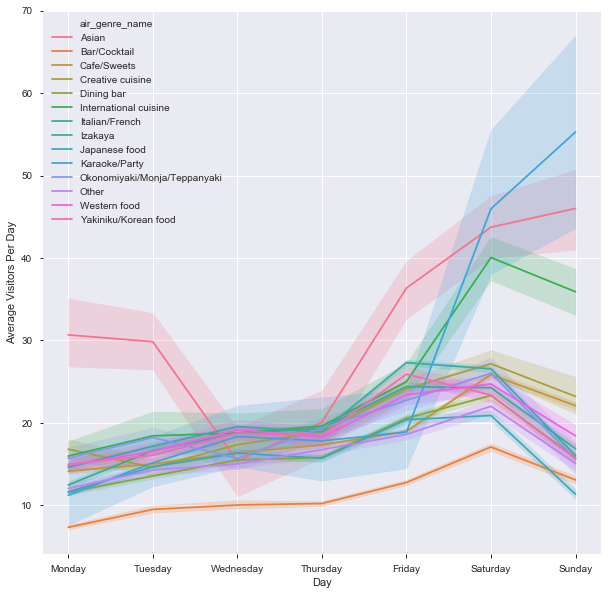

In [38]:
plt.figure(figsize=(10,10))
sns.lineplot(x=df['day_of_week'], 
             y=df['visitors'],
             hue=df['air_genre_name'])
plt.xlabel('Day')
plt.ylabel('Average Visitors Per Day')
plt.show()

There are 4 genres that behave differently than the rest.  
- Asian is consistently higher  
- Bar/Cocktail is consistently lower  
- International cuisine is similar to the rest Monday through Friday, but has a much larger increase on the weekend  
- Karaoke/Party has an even larger spike of visitors over the weekend.

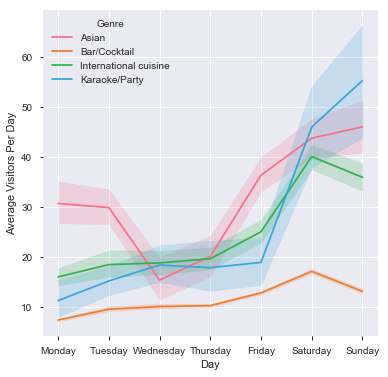

In [39]:
genre_filter = df['air_genre_name'].isin(['Asian', 'Bar/Cocktail', 'International cuisine', 'Karaoke/Party'])
plt.figure(figsize=(6, 6))
sns.lineplot(x='day_of_week', 
             y='visitors',
             hue='air_genre_name',
             legend=False,
             data=df[genre_filter])
plt.xlabel('Day')
plt.ylabel('Average Visitors Per Day')
plt.legend(['Asian', 'Bar/Cocktail', 'International cuisine', 'Karaoke/Party'], title='Genre', loc=2)
plt.show()

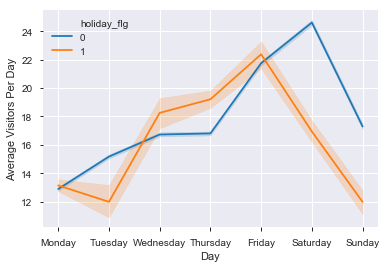

In [40]:
sns.lineplot(x='day_of_week', 
             y='visitors',
             hue='holiday_flg',
             data=df)
plt.xlabel('Day')
plt.ylabel('Average Visitors Per Day')
plt.show()

If a holiday is during the week, the number of visitors increases, but there is no increase if the holiday is on Saturday or Sunday.

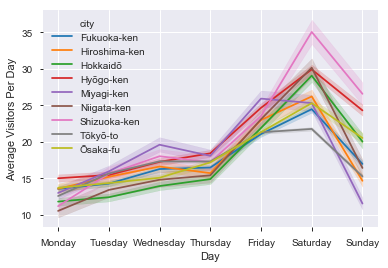

In [41]:
sns.lineplot(x=df['day_of_week'], 
             y=df['visitors'],
             hue=df['city'])
plt.xlabel('Day')
plt.ylabel('Average Visitors Per Day')
plt.show()

City appears to have very little effect in the number of visitors.

In [42]:
def anova(df, col, target='visitors'):
    samples = {}
    for group in df[col].unique():
        samples[group] = df.loc[df[col]==group, target].dropna()
    return f_oneway(*samples.values())

In [43]:
anova(df, 'day_of_week')

F_onewayResult(statistic=2253.1053104083035, pvalue=0.0)

In [44]:
anova(df, 'city')

F_onewayResult(statistic=124.23172542486387, pvalue=7.203836339536914e-209)

In [45]:
anova(df, 'prefecture')

F_onewayResult(statistic=125.45524552536752, pvalue=0.0)

In [46]:
anova(df, 'subprefecture')

F_onewayResult(statistic=124.95924001490674, pvalue=0.0)

In [47]:
anova(df, 'air_genre_name')

F_onewayResult(statistic=544.0172413899222, pvalue=0.0)

In [48]:
anova(df, 'holiday_flg')

F_onewayResult(statistic=243.42717049543293, pvalue=7.4017139668278e-55)

All of the categorical features have statistically significant F-test statistics. This means that for each feature there is at least one pair of categories that have different means. The only feature where this is surprising is 'city.' This can be made sense of by realizing that even though they are clustered together, the highest mean may be significantly different from the lowest because there is so much data.

---
## Machine Learning

In [49]:
# This is largely a function used by Max Halford in his solution to this contest
# https://github.com/MaxHalford/kaggle-recruit-restaurant/blob/master/Solution.ipynb

def extract_statistics(df, on, group_by):
    
    df.sort_values(group_by + ['calendar_date'], inplace=True)
    
    groups = df.groupby(group_by, sort=False)
    
    stats = {
        'mean': [],
        'median': [],
        'std': [],
        'max': [],
        'min': []
    }
    
    exp_alphas = [0.1, 0.25, 0.3, 0.5, 0.75]
    stats.update({'exp_{}_mean'.format(alpha): [] for alpha in exp_alphas})
    
    for _, group in groups:
        shift = group[on].shift()
        roll = shift.rolling(window=len(group), min_periods=1)
        
        stats['mean'].extend(roll.mean())
        stats['median'].extend(roll.median())
        stats['std'].extend(roll.std())
        stats['max'].extend(roll.max())
        stats['min'].extend(roll.min())
        
        for alpha in exp_alphas:
            exp = shift.ewm(alpha=alpha, adjust=False)
            stats['exp_{}_mean'.format(alpha)].extend(exp.mean())
    
    suffix = '_&_'.join(group_by)
    
    for stat_name, values in stats.items():
        df['{}_{}_by_{}'.format(on, stat_name, suffix)] = values

In [50]:
extract_statistics(df=df, on='visitors', group_by=['air_store_id'])
extract_statistics(df=df, on='visitors', group_by=['air_store_id', 'day_of_week'])

In [51]:
def train_test_split(df):
    df_dummy = pd.get_dummies(df)
    train = df_dummy.loc[(df_dummy['is_test'] == False) & (df_dummy['was_closed_False'])].copy()
    train.dropna(inplace=True)
    test = df_dummy.loc[df_dummy['is_test']].copy()

    columns_to_drop = ['visitors', 'is_test', 'was_closed_False', 'was_closed_True']
    X_train = train.drop(columns_to_drop, axis=1)
    y_train = train.loc[train['is_test'] == False, 'visitors'].copy()
    X_test = test.drop(columns_to_drop, axis=1)
    
    return X_train, y_train, X_test

In [52]:
def fit_predict(regressor, X_train, y_train, X_test, rname):
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    
    X_test = X_test.reset_index()
    submission = pd.DataFrame()
    submission['id'] = X_test['air_store_id'] + '_' + X_test['calendar_date'].astype('str')
    submission['visitors'] = y_pred
    submission.to_csv('predictions/' + rname + '.csv', index=False)

In [53]:
df.set_index('air_store_id', append=True, inplace=True)

In [54]:
X_train, y_train, X_test = train_test_split(df)

In [55]:
rfr = RandomForestRegressor(n_estimators=100, max_features='sqrt', n_jobs=-1)
fit_predict(rfr, X_train, y_train, X_test, 'rfr_subprefecture')

Public Score: 0.53086

In [56]:
X_train, y_train, X_test = train_test_split(df.drop(columns=['subprefecture']))

In [57]:
rfr = RandomForestRegressor(n_estimators=100, max_features='sqrt', n_jobs=-1)
fit_predict(rfr, X_train, y_train, X_test, 'rfr_prefecture')

Public Score: 0.53115

In [58]:
X_train, y_train, X_test = train_test_split(df.drop(columns=['subprefecture', 'prefecture']))

In [59]:
rfr = RandomForestRegressor(n_estimators=100, max_features='sqrt', n_jobs=-1)
fit_predict(rfr, X_train, y_train, X_test, 'rfr_city')

Public Score: 0.53318

The model with all location subdivisons (city, prefecture, and subprefecture) performed the best. I will train a couple of models with more trees to see if that improves performance.

In [60]:
X_train, y_train, X_test = train_test_split(df)

In [61]:
rfr = RandomForestRegressor(n_estimators=200, max_features='sqrt', n_jobs=-1)
fit_predict(rfr, X_train, y_train, X_test, 'rfr_200trees')

Public Score: 0.53148

In [62]:
rfr = RandomForestRegressor(n_estimators=300, max_features='sqrt', n_jobs=-1)
fit_predict(rfr, X_train, y_train, X_test, 'rfr_300trees')

Public Score: 0.53006

I also want to compare this to a boosted forest model.

In [63]:
gbr = GradientBoostingRegressor(n_estimators=100, max_features='sqrt', max_depth=3)
fit_predict(gbr, X_train, y_train, X_test, 'gbr_100trees_3depth')

Public Score:0.55364

In [64]:
gbr = GradientBoostingRegressor(n_estimators=500, max_features='sqrt', max_depth=3)
fit_predict(gbr, X_train, y_train, X_test, 'gbr_500trees_3depth')

Public Score: 0.53599

In [65]:
gbr = GradientBoostingRegressor(n_estimators=100, max_features='sqrt', max_depth=5)
fit_predict(gbr, X_train, y_train, X_test, 'gbr_100trees_5depth')

Public Score: 0.54583

In [66]:
gbr = GradientBoostingRegressor(n_estimators=500, max_features='sqrt', max_depth=5)
fit_predict(gbr, X_train, y_train, X_test, 'gbr_500trees_5depth')

Public Score: 0.52190

In [67]:
gbr = GradientBoostingRegressor(n_estimators=1000, max_features='sqrt', max_depth=5)
fit_predict(gbr, X_train, y_train, X_test, 'gbr_1000trees_5depth')

Public Score: 0.51598

### ARIMA

In [68]:
y_train = y_train.reset_index(level='air_store_id')

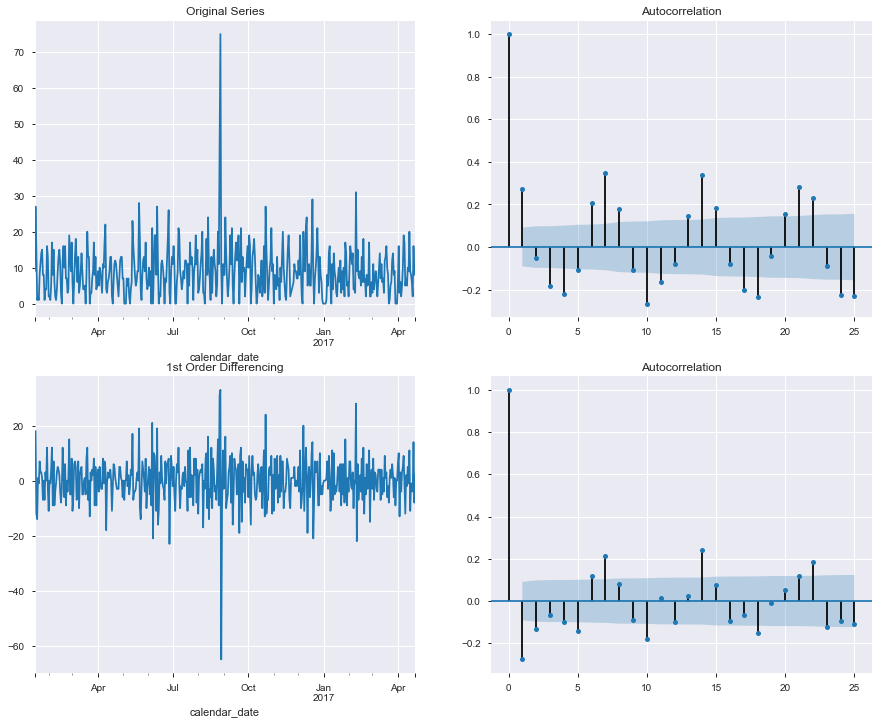

In [69]:
grouped = y_train.groupby('air_store_id')
f, axes = plt.subplots(2, 2, figsize=(15, 12))
for name, group in grouped:
    if name == 'air_efc80d3f96b3aff7':
        group = group.sort_index()
        group = group['visitors'].resample('D').sum()
        
        group.plot(ax=axes[0, 0])
        axes[0, 0].set_title('Original Series')
        plot_acf(group, lags=25, ax=axes[0, 1])
        
        group.diff().plot(ax=axes[1, 0])
        axes[1, 0].set_title('1st Order Differencing')
        plot_acf(group.diff().dropna(), lags=25, ax=axes[1, 1])
        
        plt.show()

The original series appears to be somewhat stationary. The first order differencing definitely is, but the autocorrelation plot goes far into the negative quickly which means it is over differenced. Therefore an ARMA model is all that is needed. Since only the first term of the autocorrelation plot is significant, the MA term should be 1.

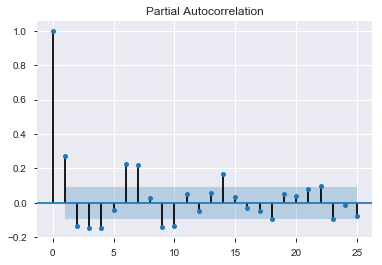

In [70]:
for name, group in grouped:
    if name == 'air_efc80d3f96b3aff7':
        group = group.sort_index()
        group = group['visitors'].resample('D').sum()
        plot_pacf(group, lags=25)       
        plt.show()

From the partial autocorrelation plot, the AR term should be between 1 and 7 since most of the first seven are significant.

In [71]:
for name, group in grouped:
    if name == 'air_efc80d3f96b3aff7': 
        group = group.sort_index()
        model = ARMA(group['visitors'].resample('D').sum(), order=(7, 1))
        model_fit = model.fit(disp=0)
        print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:               visitors   No. Observations:                  464
Model:                     ARMA(7, 1)   Log Likelihood               -1499.878
Method:                       css-mle   S.D. of innovations              6.126
Date:                Thu, 21 Nov 2019   AIC                           3019.756
Time:                        09:44:01   BIC                           3061.154
Sample:                    01-15-2016   HQIC                          3036.052
                         - 04-22-2017                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              8.9793      0.418     21.462      0.000       8.159       9.799
ar.L1.visitors     0.2680      0.136      1.964      0.050       0.001       0.535
ar.L2.visitors    -0.0686      0.058

The MA term is the least significant so I will remove it first.

In [72]:
for name, group in grouped:
    if name == 'air_efc80d3f96b3aff7': 
        group = group.sort_index()
        model = ARMA(group['visitors'].resample('D').sum(), order=(7, 0))
        model_fit = model.fit(disp=0)
        print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:               visitors   No. Observations:                  464
Model:                     ARMA(7, 0)   Log Likelihood               -1499.941
Method:                       css-mle   S.D. of innovations              6.127
Date:                Thu, 21 Nov 2019   AIC                           3017.882
Time:                        09:44:01   BIC                           3055.141
Sample:                    01-15-2016   HQIC                          3032.548
                         - 04-22-2017                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              8.9791      0.414     21.698      0.000       8.168       9.790
ar.L1.visitors     0.2219      0.045      4.900      0.000       0.133       0.311
ar.L2.visitors    -0.0561      0.046

The second term is not significant, so I will go to a first order autoregressive model.

In [73]:
for name, group in grouped:
    if name == 'air_efc80d3f96b3aff7':
        group = group.sort_index()
        model = ARMA(group['visitors'].resample('D').sum(), order=(1, 0))
        model_fit = model.fit(disp=0)
        print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:               visitors   No. Observations:                  464
Model:                     ARMA(1, 0)   Log Likelihood               -1538.400
Method:                       css-mle   S.D. of innovations              6.663
Date:                Thu, 21 Nov 2019   AIC                           3082.801
Time:                        09:44:02   BIC                           3095.221
Sample:                    01-15-2016   HQIC                          3087.690
                         - 04-22-2017                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              8.9987      0.425     21.172      0.000       8.166       9.832
ar.L1.visitors     0.2729      0.045      6.118      0.000       0.185       0.360
                                    

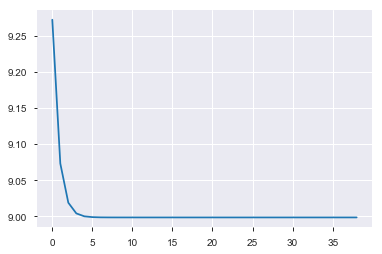

In [74]:
for name, group in grouped:
    if name == 'air_efc80d3f96b3aff7':
        group = group.sort_index()
        model = ARMA(group['visitors'].resample('D').sum(), order=(1, 0))
        model_fit = model.fit(disp=0)
        plt.plot(model_fit.forecast(steps=39)[0])

These predictions show no weekly variation.

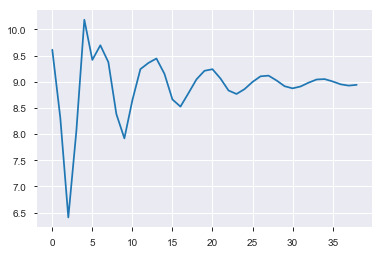

In [75]:
for name, group in grouped:
    if name == 'air_efc80d3f96b3aff7':
        group = group.sort_index()
        model = ARMA(group['visitors'].resample('D').sum(), order=(7, 0))
        model_fit = model.fit(disp=0)
        plt.plot(model_fit.forecast(steps=39)[0])

Now there is a weekly variation, but it gets smaller as the forecasting gets farther from the known data. This is likely not realistic, but it is better than no variation.

In [76]:
grouped = y_train.groupby('air_store_id')
ARMA_models = {}
for name, group in grouped:
    group = group.sort_index()
    model = ARMA(group['visitors'].resample('D').sum(), order=(7, 0))
    model_fit = model.fit(disp=0)
    ARMA_models[name] = model_fit

D:\Anaconda\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [77]:
submission = pd.DataFrame()
X_test.reset_index(inplace=True)
submission['id'] = X_test['air_store_id'] + '_' + X_test['calendar_date'].astype('str')
submission['air_store_id'] = X_test['air_store_id']
submission['visitors'] = 0

In [78]:
for store, model in ARMA_models.items():
    closed_stores = ['air_0ead98dd07e7a82a', 'air_229d7e508d9f1b5e', 'air_2703dcb33192b181', 'air_b2d8bc9c88b85f96',
                     'air_cb083b4789a8d3a2', 'air_cf22e368c1a71d53', 'air_d0a7bd3339c3d12a', 'air_d63cfa6d6ab78446']
    if store in closed_stores:
        continue
    else:
        submission.loc[submission['air_store_id']==store,'visitors'] = model.forecast(steps=39)[0]

In [79]:
submission.drop('air_store_id', axis=1).to_csv('predictions/ARMA.csv', index=False)

Public Score: 0.56343  
This is only slightly worse than the smallest boosted forest while containing only information about the number of visitors and no other features. There are two ways to combine this time series model with other features: the first is an ARIMAX model and the second s to use this as a feature in the boosted forest. You can see my testing of the ARIMAX model in the 'Machine Learning' notebook, but when I tried to run this model for all the stores, it did not converge for most stores and always had an error at some point.

In [80]:
visitors_pred_ARMA = pd.DataFrame()
for store_id, model in ARMA_models.items():
    temp = pd.concat([ARMA_models[store_id].predict(),
                      pd.DataFrame(ARMA_models[store_id].forecast(39)[0],
                                   index=pd.date_range(start='2017-04-23', end='2017-05-31'))
                     ])
    temp['air_store_id'] = store_id
    
    visitors_pred_ARMA = pd.concat([visitors_pred_ARMA, temp], axis=0)
visitors_pred_ARMA.columns = ['visitors_pred_ARMA', 'air_store_id']
visitors_pred_ARMA.index = visitors_pred_ARMA.index.rename('calendar_date')
visitors_pred_ARMA.set_index('air_store_id', append=True, inplace=True)
visitors_pred_ARMA.sort_index(inplace=True)

In [81]:
df = df.merge(visitors_pred_ARMA, how='left', on=['calendar_date', 'air_store_id'])

In [82]:
X_train, y_train, X_test = train_test_split(df)

In [83]:
gbr = GradientBoostingRegressor(n_estimators=1000, max_features='sqrt', max_depth=5)
fit_predict(gbr, X_train, y_train, X_test, 'gbr_1000trees_5depth_ARMA')

Public Score: 0.51710  
This is about the same as without the ARMA predictions. I am going to build one final large model.

In [84]:
gbr = GradientBoostingRegressor(n_estimators=10000, max_features='sqrt', max_depth=5)
fit_predict(gbr, X_train, y_train, X_test, 'gbr_10000trees_5depth_ARMA')

Public Score: 0.52337  
This is worse than the smaller model.

### What I have learned
- Using the time-series nature of these data to create new features is very important for increasing the performance of a model.
- A simple ARIMA model of the target may perform nearly as well as a model with many features.
- Models with more estimators do not necessarily perform better than smaller models. 